# Error analysis notebook - lambdamart, seed 0, test data

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum



# lambdamart, seed=0

## Set filepaths

#### Meta, DocHLevel

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/lambdamart2020_train_seed0_random_state=0.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/lambdamart2020_train_seed0hlevel_random_state=0.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/lambdamart2020_train_seed0level_random_state=0.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
annotations = '../pre_pre_processing/resources/merged-annotations.json'
features = '../pre_processing/resources/escache/lambdamart2020.csv'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)
rdf["q_num"]  = rdf.q_num.apply(lambda row: str(row))
rdf = rdf[rdf.q_num.str.contains('.0$')]

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# features
fdf = pd.read_csv(features)

In [4]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."
150,1.0,23837,"[b61145cba2cc21b90fb505b5dbd81ffc9dfb7681, 628..."


In [5]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,5438,cloud computing,0.000057,{'doc_id': '3e19046c665867bbe557685da60738a407...,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,0.000057,{'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [6]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,5438,cloud computing,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [7]:
ehldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.000860,1.890369,1.861855
258,1.295398,1.307552,0.438057


In [8]:
eldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.000096,1.890621,1.881074
258,0.285346,1.788896,1.225408


In [9]:
adf.head(2)

,id,missing_authors,authors,name,wiki,country,type,valid,auth_id,h_index,level,region
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David M. Szymanski', 'wiki': 'Texas ...",David M. Szymanski,Texas A&M University,US,academic,True,50215565.0,9.0,Advanced,Americas
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David H. Henard', 'wiki': 'North Car...",David H. Henard,North Carolina State University,US,academic,True,115002169.0,8.0,Advanced,Americas


In [10]:
fdf.head(2)

,qid,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,doc_id,qlength
0,69,12.035521,14.701091,0.0,0.0,0.0,0.0,1998.0,0.0,0.0,66b1b3cd214a635e0b6e843480b54696414fb3d6,15
1,69,14.180475,31.762882,0.0,0.0,0.0,0.0,1999.0,9.0,0.0,e90e496bd64a70bdf4eeccb72e7238421036b302,15


## Error analysis template
For Lambdamart we answer the following questions to gain insight into the points of failure of the ranker.

1. Behavior on top relevant documents  
    - How many of the top documents for this system were relevant and could they be categorized and distinguished from others?
2. Behavior on top non-relevant documents  
    - Why were top non-relevant documents retrieved
3. Behavior on bottom-ranked relevant documents  
    - Why weren't these relevant documents in the top positions
4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty, as measured by DGEE?
5. What obvious mistakes did the system make that it could have easily avoided?
6. Other features of note.
7. What should the system do to improve performance?
8. What added information would help performance? How can the system get that information?
9. Are there differences between the official NIST assessment of documents and your own assessment?


## Compare difficulties according to groupings

In [11]:
print("hlevel: ", ehldf.difference.mean(), "\tlevel: ", eldf.difference.mean())

hlevel:  0.740296845 	level:  0.662248905


We order the queries from lowest to highest DGEE according to each grouping. Then we plot the "difficulty rank" of each query according to the "hlevel" grouping against its difficulty according to the "level" grouping. This allows us to see if the DGEE for both groupings is generally in accordance or not.

In [12]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,82442,0.000000,1.846817,1.846899,0,0.000000,1.889282,1.889282
1,1,49868,0.000430,1.879661,1.856620,2,0.000381,1.890372,1.871403
2,2,107238,0.000609,1.869202,1.835515,4,0.000609,1.869202,1.835515
3,3,69,0.000860,1.890369,1.861855,1,0.000096,1.890621,1.881074
4,4,3661,0.000872,1.804406,1.778091,5,0.000614,1.804453,1.778568


Text(0.5, 0.98, 'Difficulty for H-index grouping versus econ level grouping for LambdaMart, seed 0, test data')

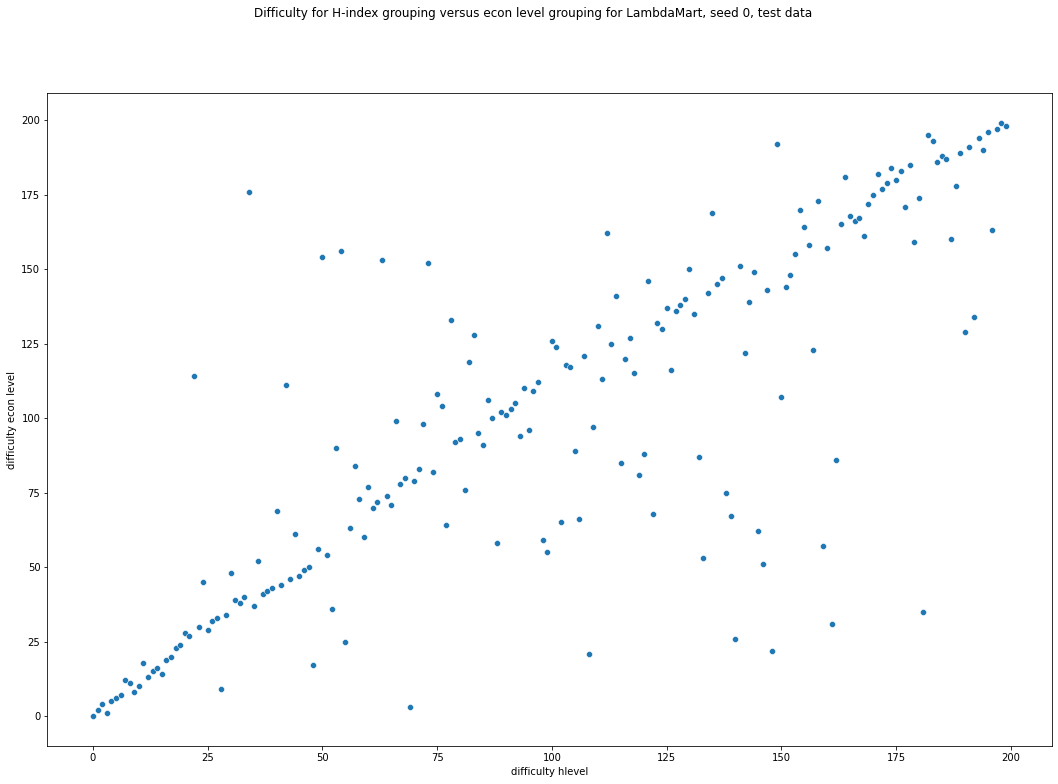

In [13]:
fig, ax = plt.subplots(1,1,figsize=(18,12))

sns.scatterplot(data=edf_m, x='difficulty hlevel', y='difficulty econ level',ax=ax)
fig.suptitle('Difficulty for H-index grouping versus econ level grouping for LambdaMart, seed 0, test data')

We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [14]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,82442,0.000000,1.868049,1.868091
1,49868,0.000405,1.885017,1.864012
3,69,0.000478,1.890495,1.871465
2,107238,0.000609,1.869202,1.835515
4,3661,0.000743,1.804429,1.778329


## Visualization

### Methods

In [15]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [16]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


In [17]:
def ranking_to_df(ranking, relevance):
    ranking = ranking[['qid','ranking']].reset_index(drop=True)
    ranking = ranking.explode('ranking')
    ranking['rank'] = ranking.groupby(level=0).cumcount()
    ranking = ranking.reset_index(drop=True)
    ranking = ranking.rename({'ranking':'doc_id'},axis=1)
    merge = pd.merge(ranking,relevance[['qid','doc_id','doc_rel']], on = ['qid', 'doc_id'], how='left')
    merge['rel'] = merge['doc_rel'].apply(lambda row: 'rel' if row == 1 else 'nonrel')
    return merge

In [18]:
rankdf = ranking_to_df(rdf,reldf)
rankdf.head()

,qid,doc_id,rank,doc_rel,rel
0,5438,b2fdee22aa02477292b858fbafcb418932732bce,0,1,rel
1,5438,993db6e50adc33307896403c83ef10399883454f,1,0,nonrel
2,5438,c50a7f1850d1770fe728b8e42200e463ca669896,2,0,nonrel
3,5438,8466964cf0884351c3e1b8444b5d71e64eb69dd6,3,0,nonrel
4,5438,1f1946887c8be228864ee23374bc0b427abf0884,4,0,nonrel


In [19]:
def plot_positions(qid, ranking, relevance):
    data = ranking[ranking.qid == qid]
    data["doc_labels"] = data.apply(lambda row: f"{row['rank']}: {row.doc_id[:4]}...", axis=1,result_type='expand')
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    sns.scatterplot(data=data, x='doc_labels', y='rel', hue='rel',ax = ax,hue_order= ['rel', 'nonrel'])
    rel = count_relgrades_qid(qid, relevance)[0]
    ax.axvline(x=rel + 0.5, color='g')
    ax.set_xticks(np.arange(len(data)))
    fig.suptitle(f'Relevance/non-relevant documents for qid {qid}')
    
    
    ax.set_xticklabels(data.doc_labels.to_list(),rotation = -70)
        
    

In [20]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [21]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

### Vis

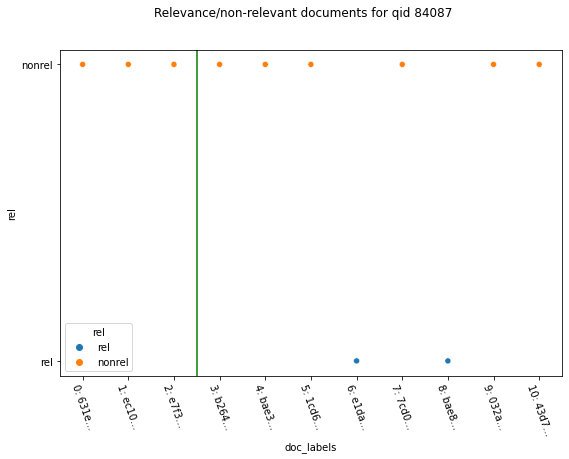

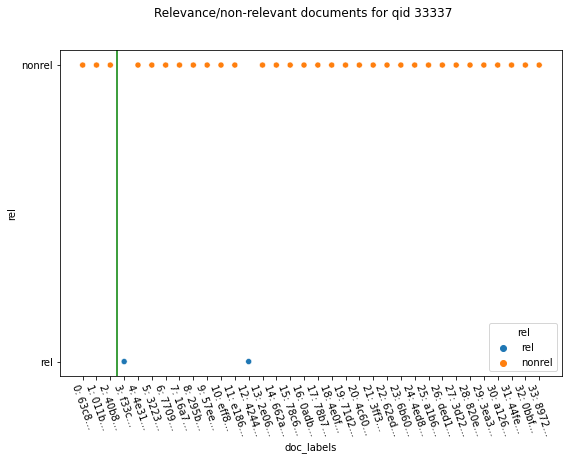

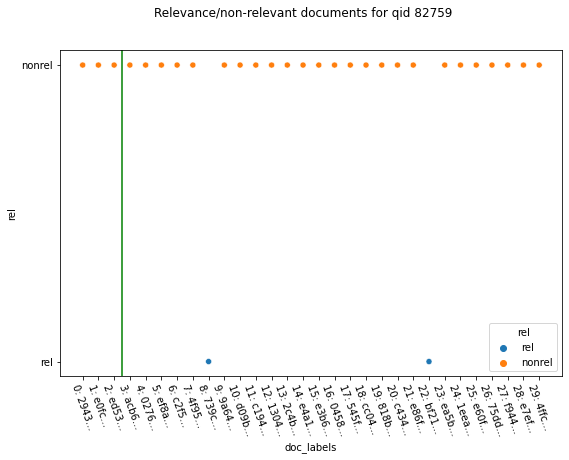

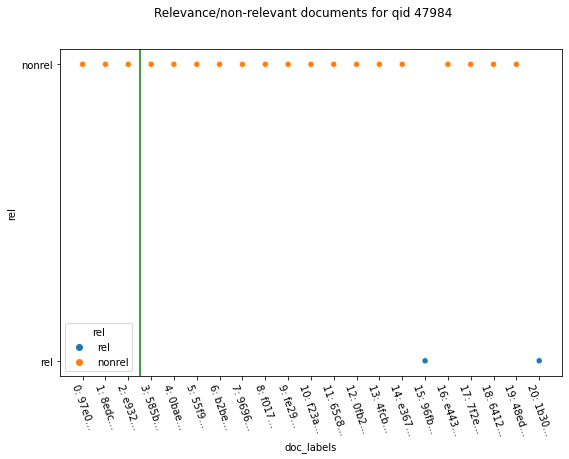

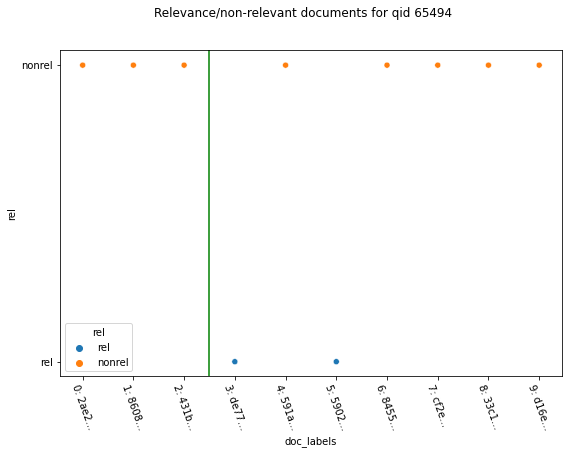

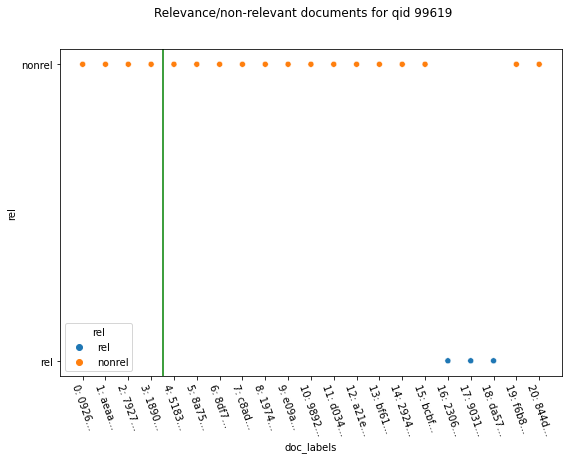

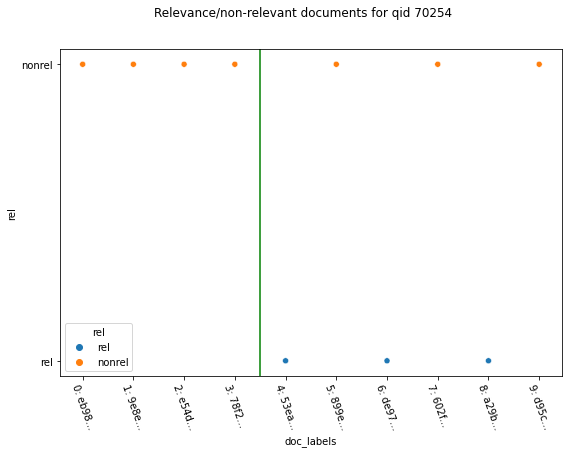

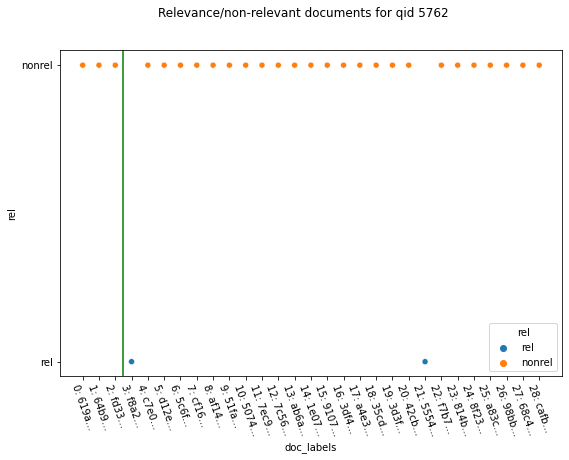

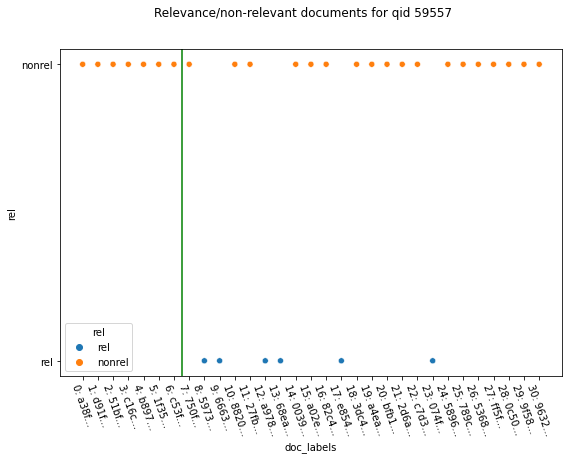

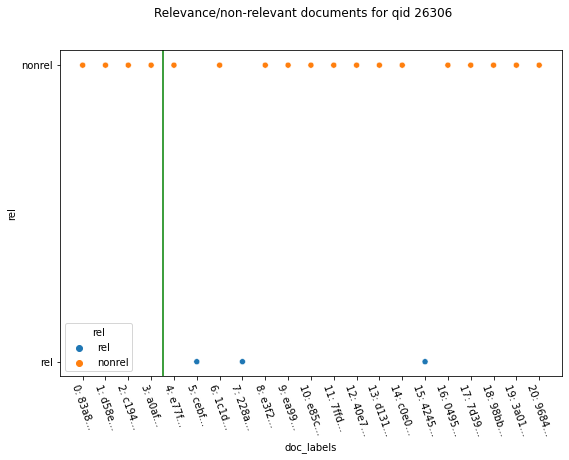

In [22]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_positions(q,rankdf,reldf)

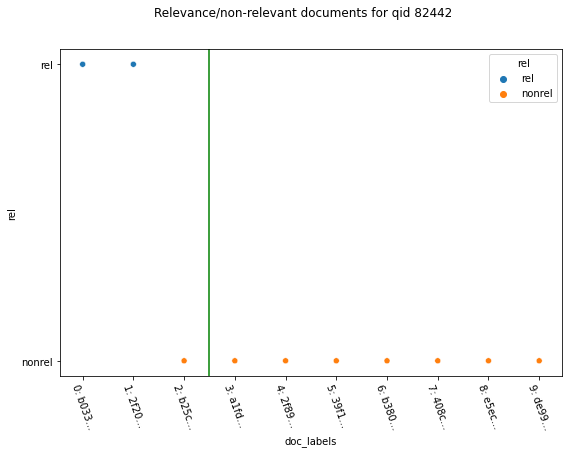

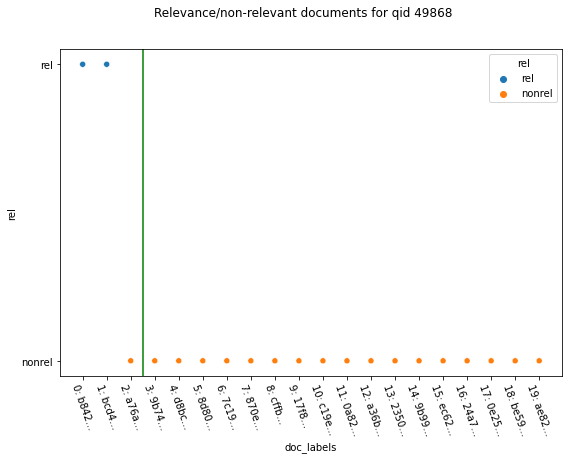

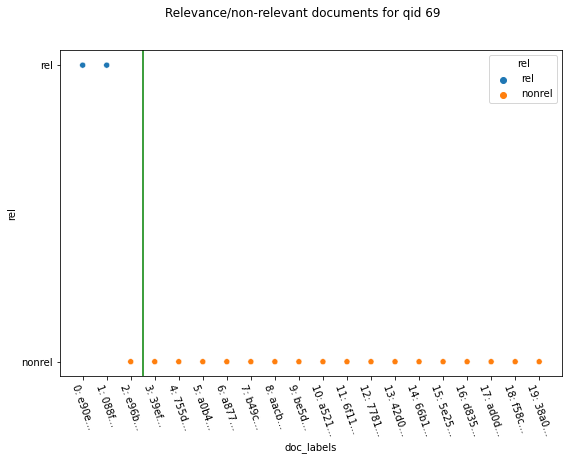

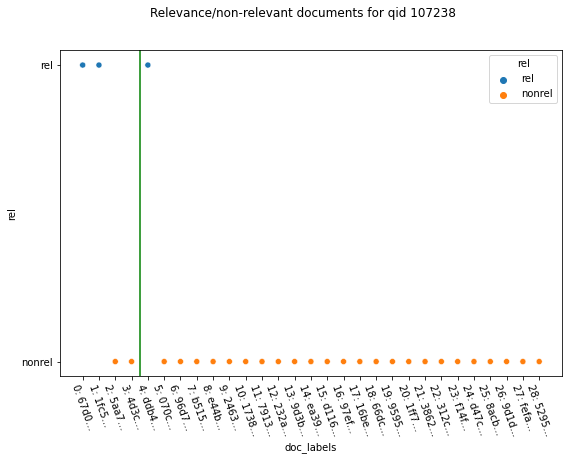

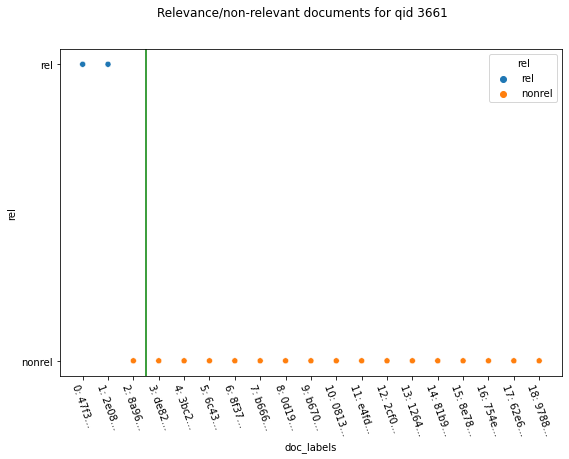

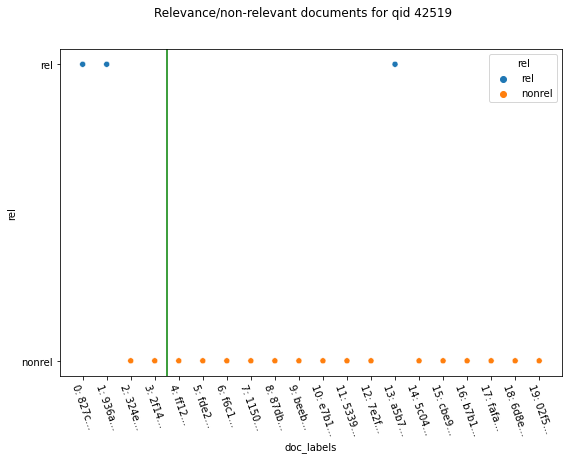

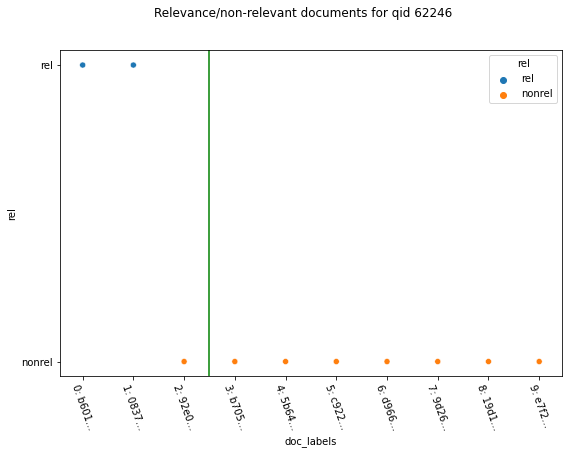

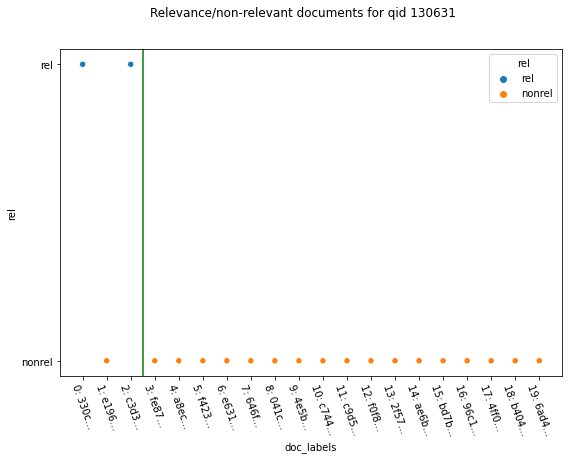

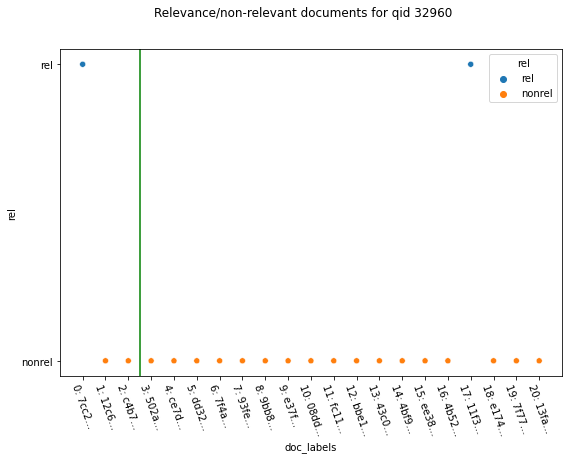

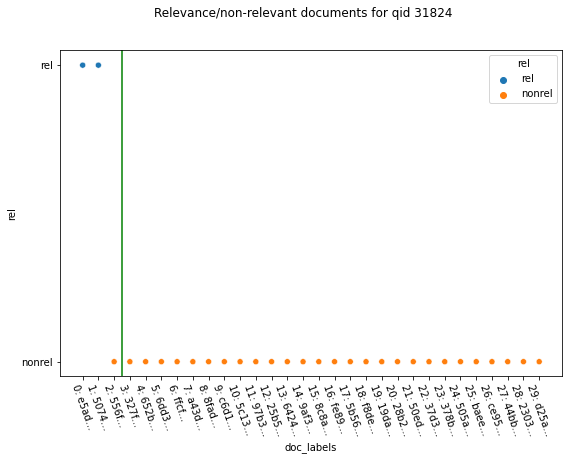

In [23]:
for q in edf.head(10).qid.to_list():
    plot_positions(q,rankdf,reldf)

## 1. Behavior on top relevant documents


### Percentage of relevant documents

In [24]:
relfrac = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

82442 	 100.0
49868 	 100.0
69 	 100.0
107238 	 66.67
3661 	 100.0
42519 	 66.67
62246 	 100.0
130631 	 50.0
32960 	 50.0
31824 	 100.0


In [25]:
np.array(relfrac).mean()

83.334

In [26]:
relfrac = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

84087 	 0.0
33337 	 0.0
82759 	 0.0
47984 	 0.0
65494 	 0.0
99619 	 0.0
70254 	 0.0
5762 	 0.0
59557 	 0.0
26306 	 0.0


In [27]:
np.array(relfrac).mean()

0.0

### ES info top relevant documents

In [28]:
inspect_doclist1 = []
for qid in edf.head(10).qid.to_list() + edf.tail(10).qid.to_list():
    temp = rankdf[rankdf.qid == qid]    
    rel = count_relgrades_qid(qid, reldf)[0]
    temp = temp.iloc[:rel]
    temp = temp[temp.doc_rel==1]
    inspect_doclist1 = inspect_doclist1 + temp.doc_id.to_list()
inspect_doclist1

['b03331a9d27c71577179563bba6fefaa518a5c74',
 '2f20f8c3c449519ccfcba784093024c25c9fb425',
 'b8421ba82c830da82dca42eadfe54f7102709b61',
 'bcd41049a43f1ec39d5bf964e62ff18c23e81a74',
 'e90e496bd64a70bdf4eeccb72e7238421036b302',
 '088f1f39e09476624088779808916769f0415522',
 '67d0391793a1b0f4383609cf59fca27a7b62ee30',
 '1fc53be8bd14c9dab3415342e99a4514581e6f2f',
 '47f3345d5a61f4221e7ee071d97dca4f4a208205',
 '2e089d5c7ee3a1815d616f85868ce41260cabab7',
 '827c52fd6902f680d6373ea3527d87b64e3d3be6',
 '936a41091ef04292a1340cdf38d5841b2d2aa190',
 'b6014ad3ea54c5b3ad7c7a24a20a5417bd41d7d9',
 '083703ddd32370fae826c039aebf881c05887111',
 '330c2cc0d6b7c9fe584cf8a02b7698b4ebee923d',
 '7cc27a507d20cfc84c6b4d4b8ed02ab8e7305eb3',
 'e5addd21a30b8936cf1d5757fc726e72bc7af976',
 '507467eb580b4ce2324c6ff4a035068e12b6d43f']

#### Create df with difficulty info and rankings

In [29]:
difdf1 = pd.merge(edf['qid'].reset_index().rename({'index':'difficulty'},axis=1)[['qid','difficulty']],rankdf[['qid','doc_id','rank','doc_rel']], on='qid')
difdf1 = difdf1[(difdf1.doc_rel == 1) & (difdf1.qid.isin(edf.head(10).qid.tolist())) & (difdf1.doc_id.isin(inspect_doclist1))]
difdf1.head()

,qid,difficulty,doc_id,rank,doc_rel
0,82442,0,b03331a9d27c71577179563bba6fefaa518a5c74,0,1
1,82442,0,2f20f8c3c449519ccfcba784093024c25c9fb425,1,1
10,49868,1,b8421ba82c830da82dca42eadfe54f7102709b61,0,1
11,49868,1,bcd41049a43f1ec39d5bf964e62ff18c23e81a74,1,1
30,69,3,e90e496bd64a70bdf4eeccb72e7238421036b302,0,1


#### Get ES information

In [30]:
es = Elasticsearch([{'timeout':200}])

In [31]:
res = es.search(index='semanticscholar2020og',body={"size": len(inspect_doclist1), "query": {"ids" : {"values" : inspect_doclist1}}})

##### Get features

In [32]:
from attrdict import AttrDict
res = AttrDict(res)

In [33]:
features = ['title', 'paperAbstract', 'entities', 'venue','journalName', 'author_names','year','inCitations','outCitations','qlen']

In [34]:
features_dict = {hit['_id']: {k:v for k,v in hit['_source'].items() if k in features} for hit in res.hits.hits}

#### Are there any empty fields for the top relevant documents?

In [35]:
difdf1

,qid,difficulty,doc_id,rank,doc_rel
0,82442,0,b03331a9d27c71577179563bba6fefaa518a5c74,0,1
1,82442,0,2f20f8c3c449519ccfcba784093024c25c9fb425,1,1
10,49868,1,b8421ba82c830da82dca42eadfe54f7102709b61,0,1
11,49868,1,bcd41049a43f1ec39d5bf964e62ff18c23e81a74,1,1
30,69,3,e90e496bd64a70bdf4eeccb72e7238421036b302,0,1
31,69,3,088f1f39e09476624088779808916769f0415522,1,1
50,107238,2,67d0391793a1b0f4383609cf59fca27a7b62ee30,0,1
51,107238,2,1fc53be8bd14c9dab3415342e99a4514581e6f2f,1,1
79,3661,4,47f3345d5a61f4221e7ee071d97dca4f4a208205,0,1
80,3661,4,2e089d5c7ee3a1815d616f85868ce41260cabab7,1,1


In [36]:
emptyfeaturedict = {}
for idd, resdict in features_dict.items():
    if not idd in emptyfeaturedict:
        emptyfeaturedict[idd] = []
    for k,v in resdict.items():
        if v == [] or v == '' or v == 0:
            emptyfeaturedict[idd].append(k)
        # if v == 'year' and v == 0:
        #     emptyfeaturedict[idd].append(k)
emptyfeaturedict    

{'e90e496bd64a70bdf4eeccb72e7238421036b302': ['entities',
  'outCitations',
  'venue',
  'journalName'],
 'bcd41049a43f1ec39d5bf964e62ff18c23e81a74': ['entities',
  'outCitations',
  'venue',
  'journalName'],
 '936a41091ef04292a1340cdf38d5841b2d2aa190': ['entities',
  'outCitations',
  'venue'],
 '2f20f8c3c449519ccfcba784093024c25c9fb425': ['entities',
  'outCitations',
  'venue'],
 '7cc27a507d20cfc84c6b4d4b8ed02ab8e7305eb3': ['entities'],
 '507467eb580b4ce2324c6ff4a035068e12b6d43f': ['entities', 'venue'],
 'b8421ba82c830da82dca42eadfe54f7102709b61': ['entities',
  'outCitations',
  'venue'],
 '2e089d5c7ee3a1815d616f85868ce41260cabab7': ['entities', 'outCitations'],
 'b6014ad3ea54c5b3ad7c7a24a20a5417bd41d7d9': ['entities',
  'outCitations',
  'venue'],
 'e5addd21a30b8936cf1d5757fc726e72bc7af976': ['entities'],
 '827c52fd6902f680d6373ea3527d87b64e3d3be6': ['entities',
  'outCitations',
  'venue',
  'journalName'],
 'b03331a9d27c71577179563bba6fefaa518a5c74': ['entities',
  'outCitation

In [37]:
for f in features:
    difdf1[f] = 1
    difdf1[f] = difdf1.apply(lambda df: 0 if f in emptyfeaturedict[df.doc_id] else 1,axis = 1)

In [38]:
difdf1

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,qlen
0,82442,0,b03331a9d27c71577179563bba6fefaa518a5c74,0,1,1,1,0,0,1,1,1,1,0,1
1,82442,0,2f20f8c3c449519ccfcba784093024c25c9fb425,1,1,1,1,0,0,1,1,1,1,0,1
10,49868,1,b8421ba82c830da82dca42eadfe54f7102709b61,0,1,1,1,0,0,1,1,1,1,0,1
11,49868,1,bcd41049a43f1ec39d5bf964e62ff18c23e81a74,1,1,1,1,0,0,0,1,1,1,0,1
30,69,3,e90e496bd64a70bdf4eeccb72e7238421036b302,0,1,1,1,0,0,0,1,1,1,0,1
31,69,3,088f1f39e09476624088779808916769f0415522,1,1,1,1,0,1,1,1,1,1,1,1
50,107238,2,67d0391793a1b0f4383609cf59fca27a7b62ee30,0,1,1,0,0,0,0,1,1,1,0,1
51,107238,2,1fc53be8bd14c9dab3415342e99a4514581e6f2f,1,1,1,0,0,0,1,1,1,1,0,1
79,3661,4,47f3345d5a61f4221e7ee071d97dca4f4a208205,0,1,1,1,0,1,1,1,1,1,0,1
80,3661,4,2e089d5c7ee3a1815d616f85868ce41260cabab7,1,1,1,1,0,1,1,1,1,1,0,1


#### What is the length of the queries of the top and bottom queries?

In [39]:
edfreldf = pd.merge(edf,reldf[['qid','query']].drop_duplicates(), on=['qid'],how='left')
edfreldf['qlen'] = edfreldf['query'].apply(lambda row: len(row))
edfreldf.head(10)

,qid,difference,disparity,relevance,query,qlen
0,82442,0.000000,1.868049,1.868091,materialism,11
1,49868,0.000405,1.885017,1.864012,mesopotamia,11
2,69,0.000478,1.890495,1.871465,disney fantasia,15
3,107238,0.000609,1.869202,1.835515,feynman,7
4,3661,0.000743,1.804429,1.778329,what is covid 19,16
5,42519,0.000976,1.890582,1.847635,the joy luck club,17
6,62246,0.001863,1.726863,1.686415,auto insurance fraud,20
7,130631,0.005174,1.941736,1.844245,critical writing assessment esol,32
8,32960,0.006378,1.935420,1.865382,stinging nettle,15
9,31824,0.006897,1.628122,1.672977,students attitudes towards online selling,41


In [40]:
edfreldf.tail(10)

,qid,difference,disparity,relevance,query,qlen
190,26306,2.291736,1.950387,0.315648,faster r-cnn,12
191,59557,2.343315,2.185950,0.563346,morpheme,8
192,5762,2.424688,2.022435,0.424355,fine art,8
193,70254,2.650135,3.532911,0.931806,paralympic volleyball,21
194,99619,2.777287,1.969398,0.482680,elder abuse,11
195,65494,2.922439,1.719612,0.280745,dominant pole for higher order system,37
196,47984,3.218583,3.121680,0.354660,etizolam,8
197,82759,3.724659,2.967871,0.269067,medicine with ai,16
198,33337,4.072953,3.184743,0.361986,tik tok,7
199,84087,4.259558,3.117286,0.274122,music and brain,15


In [41]:
print(edfreldf.head(10).qlen.mean(), edfreldf.tail(10).qlen.mean())

18.5 14.3


In [42]:
pd.merge(edf,reldf[['qid','query']].drop_duplicates(), on=['qid'],how='left').tail(10)

,qid,difference,disparity,relevance,query
190,26306,2.291736,1.950387,0.315648,faster r-cnn
191,59557,2.343315,2.185950,0.563346,morpheme
192,5762,2.424688,2.022435,0.424355,fine art
193,70254,2.650135,3.532911,0.931806,paralympic volleyball
194,99619,2.777287,1.969398,0.482680,elder abuse
195,65494,2.922439,1.719612,0.280745,dominant pole for higher order system
196,47984,3.218583,3.121680,0.354660,etizolam
197,82759,3.724659,2.967871,0.269067,medicine with ai
198,33337,4.072953,3.184743,0.361986,tik tok
199,84087,4.259558,3.117286,0.274122,music and brain


#### What are the feature values of the top and bottom queries?

In [43]:
diffdf1 = difdf1.copy()

In [44]:
diffdf1.head()

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,qlen
0,82442,0,b03331a9d27c71577179563bba6fefaa518a5c74,0,1,1,1,0,0,1,1,1,1,0,1
1,82442,0,2f20f8c3c449519ccfcba784093024c25c9fb425,1,1,1,1,0,0,1,1,1,1,0,1
10,49868,1,b8421ba82c830da82dca42eadfe54f7102709b61,0,1,1,1,0,0,1,1,1,1,0,1
11,49868,1,bcd41049a43f1ec39d5bf964e62ff18c23e81a74,1,1,1,1,0,0,0,1,1,1,0,1
30,69,3,e90e496bd64a70bdf4eeccb72e7238421036b302,0,1,1,1,0,0,0,1,1,1,0,1


In [45]:
featm1 = pd.merge(diffdf1[['qid','difficulty','doc_id','rank','doc_rel']],fdf, on =['qid','doc_id'])
featm1

,qid,difficulty,doc_id,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
0,82442,0,b03331a9d27c71577179563bba6fefaa518a5c74,0,1,14.233805,13.461378,0.0,0.0,0.000000,0.000000,2006.0,66.0,0.0,11
1,82442,0,2f20f8c3c449519ccfcba784093024c25c9fb425,1,1,14.233805,14.740262,0.0,0.0,0.000000,0.000000,2003.0,138.0,0.0,11
2,49868,1,b8421ba82c830da82dca42eadfe54f7102709b61,0,1,15.135798,20.359747,0.0,0.0,0.000000,0.000000,2006.0,4.0,0.0,11
3,49868,1,bcd41049a43f1ec39d5bf964e62ff18c23e81a74,1,1,15.863433,15.339437,0.0,0.0,0.000000,0.000000,2002.0,7.0,0.0,11
4,69,3,e90e496bd64a70bdf4eeccb72e7238421036b302,0,1,14.180475,31.762882,0.0,0.0,0.000000,0.000000,1999.0,9.0,0.0,15
5,69,3,088f1f39e09476624088779808916769f0415522,1,1,13.552517,12.609324,0.0,0.0,0.000000,0.000000,2004.0,35.0,27.0,15
6,107238,2,67d0391793a1b0f4383609cf59fca27a7b62ee30,0,1,13.245623,0.000000,0.0,0.0,0.000000,16.174593,1963.0,54.0,0.0,7
7,107238,2,1fc53be8bd14c9dab3415342e99a4514581e6f2f,1,1,12.711554,0.000000,0.0,0.0,0.000000,11.642795,1964.0,69.0,0.0,7
8,3661,4,47f3345d5a61f4221e7ee071d97dca4f4a208205,0,1,22.834154,16.354443,0.0,0.0,0.000000,0.000000,2020.0,6.0,0.0,16
9,3661,4,2e089d5c7ee3a1815d616f85868ce41260cabab7,1,1,24.172628,15.418266,0.0,0.0,0.000000,0.000000,2020.0,4.0,0.0,16


In [46]:
featm1.describe()

,qid,difficulty,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
count,18.000000,18.000000,18.000000,18.0,18.000000,18.000000,18.0,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,51295.833333,4.055556,0.444444,1.0,19.387703,18.950217,0.0,0.0,0.461353,1.545410,2001.111111,36.611111,4.444444,17.944444
std,38936.057976,2.754082,0.511310,0.0,7.204435,10.626534,0.0,0.0,1.957356,4.564459,15.740128,41.568001,9.056829,10.108076
min,69.000000,0.000000,0.000000,1.0,12.711554,0.000000,0.0,0.0,0.000000,0.000000,1963.000000,1.000000,0.000000,7.000000
25%,31824.000000,2.000000,0.000000,1.0,14.193807,13.781099,0.0,0.0,0.000000,0.000000,1999.750000,4.500000,0.000000,11.000000
50%,46193.500000,4.000000,0.000000,1.0,15.499616,15.886354,0.0,0.0,0.000000,0.000000,2004.000000,9.000000,0.000000,15.500000
75%,77393.000000,6.000000,1.000000,1.0,23.998799,30.056343,0.0,0.0,0.000000,0.000000,2007.500000,67.500000,2.250000,19.250000
max,130631.000000,9.000000,1.000000,1.0,36.016860,36.515980,0.0,0.0,8.304359,16.174593,2020.000000,138.000000,27.000000,41.000000


In [47]:
featm1.mean()

qid               51295.833333
difficulty            4.055556
rank                  0.444444
doc_rel               1.000000
title_score          19.387703
abstract_score       18.950217
entities_score        0.000000
venue_score           0.000000
journal_score         0.461353
authors_score         1.545410
year               2001.111111
inCitations          36.611111
outCitations          4.444444
qlength              17.944444
dtype: float64

## 2. Behavior on top non-relevant documents  
Can these documents be categorized and distinguished from other documents?

### Percentage of non-relevant documents

In [48]:
fraclist = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / ( num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

82442 	 0.0
49868 	 0.0
69 	 0.0
107238 	 33.33
3661 	 0.0
42519 	 33.33
62246 	 0.0
130631 	 50.0
32960 	 50.0
31824 	 0.0


In [49]:
np.array(fraclist).mean()

16.666

In [50]:
fraclist = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / ( num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

84087 	 100.0
33337 	 100.0
82759 	 100.0
47984 	 100.0
65494 	 100.0
99619 	 100.0
70254 	 100.0
5762 	 100.0
59557 	 100.0
26306 	 100.0


In [51]:
np.array(fraclist).mean()

100.0

### ES info top non-relevant documents

In [52]:
inspect_doclist2 = []
for qid in edf.head(10).qid.to_list() + edf.tail(10).qid.to_list():
    temp = rankdf[rankdf.qid == qid]    
    rel = count_relgrades_qid(qid, reldf)[0]
    temp = temp.iloc[:rel]
    temp = temp[temp.doc_rel==0]
    inspect_doclist2 = inspect_doclist2 + temp.doc_id.to_list()
print(len(inspect_doclist2))
inspect_doclist2

31


['5aa7e4c9602086f92a93ec72a62ff50ea27ae09e',
 '324eee3df557b3549ff03d6669825cde971fe1c2',
 'e196a192735407e753f724cc150c661aa63ad259',
 '12c6e366170746e8b2bdbd45886b23042dd61c16',
 '83a811fd947415df2413d15386dbc558f07595cb',
 'd58ec9c62a4840528f74444c0f2fd56a607b44f3',
 'c194596aebe5b1cd6a789584516ac44d4817364c',
 'a38f12364618ab6647d1d8a5e0a0e281ffe3012e',
 'd91f42a2c25e72e6e02d9e1f3769f8d076d2fa4d',
 '51bf4daef8fa5f3db1583667dd09c83d589b672d',
 'c16c23b613109880dcfa3dda55c574d6ed220137',
 'b897dfab889cb44edbfc7aaa64ddb66b8f53e778',
 '1f358aa4d78e8ea6c04b61bdc20777dbe0521df6',
 '619a683a1526cc7e5565776c39f8d1788ba67c7e',
 '64b9bb77706adcc052e8449820f76a8bf4c239a8',
 'eb98887a15e3e220a49d83d565cbebc89b3b55a1',
 '9e8e67621633d88e0fdf99d8381063de56aa1c23',
 'e54d3c889d1aa5c2acb287571207d243b7901862',
 '0926275f49e03ef37e83a67e09bef1ad6cc76931',
 'aeaa00e44854526c8807efa9ba47a69355594a90',
 '792751c8e0953c82a111266c43ddc76236025b17',
 '2ae20c6159d9fa24c605a5163d61666ba3512b65',
 '860813d0

#### Create df with difficulty info and rankings

In [53]:
difdf2 = pd.merge(edf['qid'].reset_index().rename({'index':'difficulty'},axis=1)[['qid','difficulty']],rankdf[['qid','doc_id','rank','doc_rel']], on='qid')
difdf2 = difdf2[(difdf2.doc_rel == 0) & (difdf2.qid.isin(edf.head(10).qid.tolist() + edf.tail(10).qid.tolist())) & (difdf2.doc_id.isin(inspect_doclist2))]
print(len(difdf2))
difdf2.head()

31


,qid,difficulty,doc_id,rank,doc_rel
52,107238,2,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,2,0
100,42519,5,324eee3df557b3549ff03d6669825cde971fe1c2,2,0
129,130631,9,e196a192735407e753f724cc150c661aa63ad259,1,0
149,32960,8,12c6e366170746e8b2bdbd45886b23042dd61c16,1,0
4608,26306,183,83a811fd947415df2413d15386dbc558f07595cb,0,0


#### Get ES information

In [54]:
es = Elasticsearch([{'timeout':300}])

In [55]:
res = es.search(index='semanticscholar2020og',body={"size": len(inspect_doclist2), "query": {"ids" : {"values" : inspect_doclist2}}})

##### Get features

In [56]:
from attrdict import AttrDict
res = AttrDict(res)

In [57]:
features = ['title', 'paperAbstract', 'entities', 'venue','journalName', 'author_names','year','inCitations','outCitations','qlen']

In [58]:
features_dict = {hit['_id']: {k:v for k,v in hit['_source'].items() if k in features} for hit in res.hits.hits}

In [59]:
len(features_dict)

31

In [60]:
feature_df = pd.DataFrame([dict({'doc_id':k}, **v) for k, v in features_dict.items()])
feature_df

,doc_id,title,paperAbstract,entities,author_names,inCitations,outCitations,year,venue,journalName
0,e54d3c889d1aa5c2acb287571207d243b7901862,Technology in Paralympic sport: performance en...,BACKGROUND\nPeople with disabilities often dep...,[],[Brendan J. Burkett],48,24,2010,British journal of sports medicine,British journal of sports medicine
1,324eee3df557b3549ff03d6669825cde971fe1c2,On Feminism of Joy Luck Club,From the three aspects of resisting the mascul...,[],[Zhou Yan],1,0,2008,,Journal of Hunan Metallurgical Professional Te...
2,eb98887a15e3e220a49d83d565cbebc89b3b55a1,Case Study: The USA Paralympic Volleyball Coac...,A group of American University Graduate Studen...,[],[Mark Mann],1,0,2016,,
3,0926275f49e03ef37e83a67e09bef1ad6cc76931,Reciprocal Abuse: Elder Neglect and Abuse by P...,ABSTRACT The aim of the study was to determine...,[],"[Neslihan Keser Özcan, Nur Elçin Boyacıoğlu, E...",3,23,2017,Archives of psychiatric nursing,Archives of Psychiatric Nursing
4,b897dfab889cb44edbfc7aaa64ddb66b8f53e778,Morpheme-Specific Phonology: Constraint Indexa...,This paper argues that exceptions and other in...,[],[Joe Pater],109,60,2009,,
5,294324d81224b7026a4f70af3d1d26210143f598,Explainable AI (ex-AI),"Zusammenfassung,,Explainable AI“ ist kein neue...",[],[Andreas Holzinger],7,13,2018,Informatik-Spektrum,Informatik-Spektrum
6,12c6e366170746e8b2bdbd45886b23042dd61c16,Urtica dioica (Stinging Nettle): A Neglected P...,"Urtica dioica (stinging nettle), is a perennia...",[],"[Gionata De Vico, Vincenzo Guida, Francesca Ca...",2,40,2018,Front. Physiol.,Frontiers in Physiology
7,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,The Feynman lectures on physics : mainly mecha...,,[],[Richard Phillips Feynman],34,0,1963,,
8,631e7b214dfc333d433f42aca88b39edf5c3ee73,Music and brain,,[],[Rubia Vila Fj],0,0,2009,,Anales de la Real Academia Nacional de Medicina
9,c16c23b613109880dcfa3dda55c574d6ed220137,Effects of Morpheme Boundaries on Intergestura...,This paper examines the effects of morpheme bo...,[],[Taehong Cho],57,43,2001,Phonetica,Phonetica


#### Which fields are empty? Which are not?

In [61]:
emptyfeaturedict = {}
for idd, resdict in features_dict.items():
    if not idd in emptyfeaturedict:
        emptyfeaturedict[idd] = []
    for k,v in resdict.items():
        if v == [] or v == '' or v == 0:
            emptyfeaturedict[idd].append(k)
        # if v == 'year' and v == 0:
        #     emptyfeaturedict[idd].append(k)
emptyfeaturedict    

{'e54d3c889d1aa5c2acb287571207d243b7901862': ['entities'],
 '324eee3df557b3549ff03d6669825cde971fe1c2': ['entities',
  'outCitations',
  'venue'],
 'eb98887a15e3e220a49d83d565cbebc89b3b55a1': ['entities',
  'outCitations',
  'venue',
  'journalName'],
 '0926275f49e03ef37e83a67e09bef1ad6cc76931': ['entities'],
 'b897dfab889cb44edbfc7aaa64ddb66b8f53e778': ['entities',
  'venue',
  'journalName'],
 '294324d81224b7026a4f70af3d1d26210143f598': ['entities'],
 '12c6e366170746e8b2bdbd45886b23042dd61c16': ['entities'],
 '5aa7e4c9602086f92a93ec72a62ff50ea27ae09e': ['paperAbstract',
  'entities',
  'outCitations',
  'venue',
  'journalName'],
 '631e7b214dfc333d433f42aca88b39edf5c3ee73': ['paperAbstract',
  'entities',
  'inCitations',
  'outCitations',
  'venue'],
 'c16c23b613109880dcfa3dda55c574d6ed220137': ['entities'],
 '51bf4daef8fa5f3db1583667dd09c83d589b672d': ['entities'],
 '2ae20c6159d9fa24c605a5163d61666ba3512b65': ['entities'],
 '63c89dd9c9b3adbc0bc59430ac7341a7b3dd37ee': ['entities', '

In [63]:
for f in features:
    difdf2[f] = 1
    difdf2[f] = difdf2.apply(lambda df: 0 if f in emptyfeaturedict[df.doc_id] else 1,axis = 1)

In [64]:
edfreldf = pd.merge(edf,reldf[['qid','query']].drop_duplicates(), on=['qid'],how='left')
edfreldf['qlen'] = edfreldf['query'].apply(lambda row: len(row))
edfreldf.head(10)

,qid,difference,disparity,relevance,query,qlen
0,82442,0.000000,1.868049,1.868091,materialism,11
1,49868,0.000405,1.885017,1.864012,mesopotamia,11
2,69,0.000478,1.890495,1.871465,disney fantasia,15
3,107238,0.000609,1.869202,1.835515,feynman,7
4,3661,0.000743,1.804429,1.778329,what is covid 19,16
5,42519,0.000976,1.890582,1.847635,the joy luck club,17
6,62246,0.001863,1.726863,1.686415,auto insurance fraud,20
7,130631,0.005174,1.941736,1.844245,critical writing assessment esol,32
8,32960,0.006378,1.935420,1.865382,stinging nettle,15
9,31824,0.006897,1.628122,1.672977,students attitudes towards online selling,41


In [66]:
featdf = pd.merge(difdf2[['qid','difficulty','doc_id','rank','doc_rel','title','paperAbstract','entities','venue','journalName','author_names','year','inCitations', 'outCitations']],edfreldf[['qid','query','qlen']],on='qid')
featdf.head()

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,query,qlen
0,107238,2,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,2,0,1,0,0,0,0,1,1,1,0,feynman,7
1,42519,5,324eee3df557b3549ff03d6669825cde971fe1c2,2,0,1,1,0,0,1,1,1,1,0,the joy luck club,17
2,130631,9,e196a192735407e753f724cc150c661aa63ad259,1,0,1,1,0,0,1,1,1,1,1,critical writing assessment esol,32
3,32960,8,12c6e366170746e8b2bdbd45886b23042dd61c16,1,0,1,1,0,1,1,1,1,1,1,stinging nettle,15
4,26306,183,83a811fd947415df2413d15386dbc558f07595cb,0,0,1,1,0,1,1,1,1,1,1,faster r-cnn,12


##### value_counts

In [67]:
for f in features:
    print(featdf[f].value_counts())

1    31
Name: title, dtype: int64
1    29
0     2
Name: paperAbstract, dtype: int64
0    31
Name: entities, dtype: int64
1    19
0    12
Name: venue, dtype: int64
1    22
0     9
Name: journalName, dtype: int64
1    31
Name: author_names, dtype: int64
1    31
Name: year, dtype: int64
1    28
0     3
Name: inCitations, dtype: int64
1    23
0     8
Name: outCitations, dtype: int64
8     10
21     3
15     3
12     3
11     3
7      3
16     2
37     2
17     1
32     1
Name: qlen, dtype: int64


In [68]:
feature_df

,doc_id,title,paperAbstract,entities,author_names,inCitations,outCitations,year,venue,journalName
0,e54d3c889d1aa5c2acb287571207d243b7901862,Technology in Paralympic sport: performance en...,BACKGROUND\nPeople with disabilities often dep...,[],[Brendan J. Burkett],48,24,2010,British journal of sports medicine,British journal of sports medicine
1,324eee3df557b3549ff03d6669825cde971fe1c2,On Feminism of Joy Luck Club,From the three aspects of resisting the mascul...,[],[Zhou Yan],1,0,2008,,Journal of Hunan Metallurgical Professional Te...
2,eb98887a15e3e220a49d83d565cbebc89b3b55a1,Case Study: The USA Paralympic Volleyball Coac...,A group of American University Graduate Studen...,[],[Mark Mann],1,0,2016,,
3,0926275f49e03ef37e83a67e09bef1ad6cc76931,Reciprocal Abuse: Elder Neglect and Abuse by P...,ABSTRACT The aim of the study was to determine...,[],"[Neslihan Keser Özcan, Nur Elçin Boyacıoğlu, E...",3,23,2017,Archives of psychiatric nursing,Archives of Psychiatric Nursing
4,b897dfab889cb44edbfc7aaa64ddb66b8f53e778,Morpheme-Specific Phonology: Constraint Indexa...,This paper argues that exceptions and other in...,[],[Joe Pater],109,60,2009,,
5,294324d81224b7026a4f70af3d1d26210143f598,Explainable AI (ex-AI),"Zusammenfassung,,Explainable AI“ ist kein neue...",[],[Andreas Holzinger],7,13,2018,Informatik-Spektrum,Informatik-Spektrum
6,12c6e366170746e8b2bdbd45886b23042dd61c16,Urtica dioica (Stinging Nettle): A Neglected P...,"Urtica dioica (stinging nettle), is a perennia...",[],"[Gionata De Vico, Vincenzo Guida, Francesca Ca...",2,40,2018,Front. Physiol.,Frontiers in Physiology
7,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,The Feynman lectures on physics : mainly mecha...,,[],[Richard Phillips Feynman],34,0,1963,,
8,631e7b214dfc333d433f42aca88b39edf5c3ee73,Music and brain,,[],[Rubia Vila Fj],0,0,2009,,Anales de la Real Academia Nacional de Medicina
9,c16c23b613109880dcfa3dda55c574d6ed220137,Effects of Morpheme Boundaries on Intergestura...,This paper examines the effects of morpheme bo...,[],[Taehong Cho],57,43,2001,Phonetica,Phonetica


##### anchor

In [70]:
pd.merge(pd.merge(difdf2[['qid','doc_id','rank']],feature_df[[f for f in feature_df.columns.to_list() if f != 'entities']], on='doc_id'),edfreldf[['qid','query','qlen']],on='qid')

,qid,doc_id,rank,title,paperAbstract,author_names,inCitations,outCitations,year,venue,journalName,query,qlen
0,107238,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,2,The Feynman lectures on physics : mainly mecha...,,[Richard Phillips Feynman],34,0,1963,,,feynman,7
1,42519,324eee3df557b3549ff03d6669825cde971fe1c2,2,On Feminism of Joy Luck Club,From the three aspects of resisting the mascul...,[Zhou Yan],1,0,2008,,Journal of Hunan Metallurgical Professional Te...,the joy luck club,17
2,130631,e196a192735407e753f724cc150c661aa63ad259,1,Diagnostic assessment of writing: A comparison...,Alderson (2005) suggests that diagnostic tests...,[Ute Knoch],69,29,2009,,Language Testing,critical writing assessment esol,32
3,32960,12c6e366170746e8b2bdbd45886b23042dd61c16,1,Urtica dioica (Stinging Nettle): A Neglected P...,"Urtica dioica (stinging nettle), is a perennia...","[Gionata De Vico, Vincenzo Guida, Francesca Ca...",2,40,2018,Front. Physiol.,Frontiers in Physiology,stinging nettle,15
4,26306,83a811fd947415df2413d15386dbc558f07595cb,0,Fine-grained Discriminative Localization via S...,Discriminative localization is essential for f...,"[Xiangteng He, Yuxin Peng, Junjie Zhao]",16,31,2017,MM '17,Proceedings of the 25th ACM international conf...,faster r-cnn,12
5,26306,d58ec9c62a4840528f74444c0f2fd56a607b44f3,1,Faster R-CNN Features for Instance Search,Image representations derived from pre-trained...,"[Amaia Salvador, Xavier Giró-i-Nieto, Ferran M...",58,25,2016,2016 IEEE Conference on Computer Vision and Pa...,2016 IEEE Conference on Computer Vision and Pa...,faster r-cnn,12
6,26306,c194596aebe5b1cd6a789584516ac44d4817364c,2,A closer look at Faster R-CNN for vehicle dete...,Faster R-CNN achieves state-of-the-art perform...,"[Quanfu Fan, Lisa M. Brown, John Smith]",45,22,2016,2016 IEEE Intelligent Vehicles Symposium (IV),2016 IEEE Intelligent Vehicles Symposium (IV),faster r-cnn,12
7,59557,a38f12364618ab6647d1d8a5e0a0e281ffe3012e,0,The role of morpheme recognition and morpholog...,This paper begins by presenting theoretical ar...,"[Carsten Elbro, Elisabeth Arnbak]",119,0,1996,Annals of dyslexia,Annals of Dyslexia,morpheme,8
8,59557,d91f42a2c25e72e6e02d9e1f3769f8d076d2fa4d,1,Infixation as Morpheme Absorption *,This article examines data from the languages ...,"[MORPHEME ABSORPTION, Ania oUBOWICZ]",4,29,2005,,,morpheme,8
9,59557,51bf4daef8fa5f3db1583667dd09c83d589b672d,2,Influence of Morpheme Polysemy on Morpheme Fre...,A hypothesis about the dependency of morpheme ...,[Andrea Krott],2,1,1999,Journal of Quantitative Linguistics,Journal of Quantitative Linguistics,morpheme,8


#### What are the feature values of the top and bottom queries?

In [71]:
diffdf2 = difdf2.copy()

In [72]:
diffdf2.head()

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,qlen
52,107238,2,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,2,0,1,0,0,0,0,1,1,1,0,1
100,42519,5,324eee3df557b3549ff03d6669825cde971fe1c2,2,0,1,1,0,0,1,1,1,1,0,1
129,130631,9,e196a192735407e753f724cc150c661aa63ad259,1,0,1,1,0,0,1,1,1,1,1,1
149,32960,8,12c6e366170746e8b2bdbd45886b23042dd61c16,1,0,1,1,0,1,1,1,1,1,1,1
4608,26306,183,83a811fd947415df2413d15386dbc558f07595cb,0,0,1,1,0,1,1,1,1,1,1,1


In [73]:
featm2 = pd.merge(diffdf2[['qid','difficulty','doc_id','rank','doc_rel']],fdf, on =['qid','doc_id'])
featm2

,qid,difficulty,doc_id,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
0,107238,2,5aa7e4c9602086f92a93ec72a62ff50ea27ae09e,2,0,12.487004,0.000000,0.0,0.00000,0.000000,16.174593,1963.0,34.0,0.0,7
1,42519,5,324eee3df557b3549ff03d6669825cde971fe1c2,2,0,36.188698,34.870716,0.0,0.00000,0.000000,0.000000,2008.0,1.0,0.0,17
2,130631,9,e196a192735407e753f724cc150c661aa63ad259,1,0,12.713791,12.811359,0.0,0.00000,0.000000,0.000000,2009.0,69.0,29.0,32
3,32960,8,12c6e366170746e8b2bdbd45886b23042dd61c16,1,0,21.393612,29.054047,0.0,0.00000,0.000000,0.000000,2018.0,2.0,40.0,15
4,26306,183,83a811fd947415df2413d15386dbc558f07595cb,0,0,27.214098,20.483044,0.0,0.00000,0.000000,0.000000,2017.0,16.0,31.0,12
5,26306,183,d58ec9c62a4840528f74444c0f2fd56a607b44f3,1,0,30.505943,26.318485,0.0,0.00000,0.000000,0.000000,2016.0,58.0,25.0,12
6,26306,183,c194596aebe5b1cd6a789584516ac44d4817364c,2,0,27.214098,27.984348,0.0,0.00000,0.000000,0.000000,2016.0,45.0,22.0,12
7,59557,182,a38f12364618ab6647d1d8a5e0a0e281ffe3012e,0,0,12.894716,13.712126,0.0,0.00000,0.000000,0.000000,1996.0,119.0,0.0,8
8,59557,182,d91f42a2c25e72e6e02d9e1f3769f8d076d2fa4d,1,0,16.443499,16.588129,0.0,0.00000,0.000000,21.400307,2005.0,4.0,29.0,8
9,59557,182,51bf4daef8fa5f3db1583667dd09c83d589b672d,2,0,18.625446,16.093561,0.0,0.00000,0.000000,0.000000,1999.0,2.0,1.0,8


In [74]:
featm2.describe()

,qid,difficulty,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
count,31.000000,31.000000,31.000000,31.0,31.000000,31.000000,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,61228.161290,166.967742,1.161290,0.0,18.605136,18.762548,0.0,0.605090,0.603836,1.212094,2007.838710,31.483871,29.000000,13.967742
std,29716.671934,63.276896,1.213721,0.0,6.104911,8.832646,0.0,3.368999,3.362017,4.740064,12.562104,52.541330,52.933291,8.356570
min,5762.000000,2.000000,0.000000,0.0,12.487004,0.000000,0.0,0.000000,0.000000,0.000000,1963.000000,0.000000,0.000000,7.000000
25%,37928.000000,182.000000,0.000000,0.0,13.589595,12.998103,0.0,0.000000,0.000000,0.000000,2005.000000,2.000000,0.500000,8.000000
50%,59557.000000,191.000000,1.000000,0.0,18.153854,16.915310,0.0,0.000000,0.000000,0.000000,2009.000000,7.000000,24.000000,11.000000
75%,82759.000000,195.500000,2.000000,0.0,20.415271,26.140648,0.0,0.000000,0.000000,0.000000,2017.000000,46.500000,29.000000,16.000000
max,130631.000000,199.000000,5.000000,0.0,36.188698,34.870716,0.0,18.757790,18.718918,21.400307,2019.000000,253.000000,302.000000,37.000000


In [75]:
featm2.mean()

qid               61228.161290
difficulty          166.967742
rank                  1.161290
doc_rel               0.000000
title_score          18.605136
abstract_score       18.762548
entities_score        0.000000
venue_score           0.605090
journal_score         0.603836
authors_score         1.212094
year               2007.838710
inCitations          31.483871
outCitations         29.000000
qlength              13.967742
dtype: float64

## 3. Which relevant documents do not appear in top positions?

### ES info top non-relevant documents

In [76]:
inspect_doclist3 = []
for qid in edf.head(10).qid.to_list() + edf.tail(10).qid.to_list():
    temp = rankdf[rankdf.qid == qid]    
    rel = count_relgrades_qid(qid, reldf)[0]
    temp = temp.iloc[rel:]
    temp = temp[temp.doc_rel==1]
    inspect_doclist3 = inspect_doclist3 + temp.doc_id.to_list()
print(len(inspect_doclist3))
inspect_doclist3

31


['ddb40f5401c9f3135c196cf585cc33c28556c5c5',
 'a5b7c7350da135cbef5e34f1718bc4b180aff853',
 'c3d3bae60f7dbec07423cbb9c1398eec4f067969',
 '11f37d2e6c03de55d1c0c7fc81093f21ca5a9699',
 'cebf2ddc8ef178b439e53d96234f668a67c20a88',
 '228a802f5902e84b777b7e1cae8617f02a1f7e92',
 '424561d8585ff8ebce7d5d07de8dbf7aae5e7270',
 '59733554f2fda47e260e3904be72b66c865f59d7',
 '6663ac43b2867d7dfba590feea49d7d9a8e90967',
 'a9787b2d269a71277e7885a6f942c4373b236030',
 '68eafa65adb0ba76aa9a6b9d49c83c19bc6e7f41',
 'e854536d09ab48bb09aa8704fec5185d6620d91b',
 '074ff810b9bdb7faee66f9d8bae9f67f1e663882',
 'f8a27b6591312fba8108500ab2e8275c92009a71',
 '55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144',
 '53ea659ec5aee4b2bb4fdabac74fba8674d83b48',
 'de9764c7f0be2556034c6d356e756e1af094262e',
 'a29bd64bba14e3844de4798fcc37f18dd5531eac',
 '2306e6e932856cc0da15a3580661f325acc8770f',
 '9031ae9bd4f0019f7f264f8fa58792cfd8106ba8',
 'da571401660b36e83369650fe918ad7acb0bcf28',
 'de778fe136a5a933be1ee8b15ed90422cff9bdd8',
 '59025308

#### Create df with difficulty info and rankings

In [77]:
difdf3 = pd.merge(edf['qid'].reset_index().rename({'index':'difficulty'},axis=1)[['qid','difficulty']],rankdf[['qid','doc_id','rank','doc_rel']], on='qid')
difdf3 = difdf3[(difdf3.doc_rel == 1) & (difdf3.qid.isin(edf.head(10).qid.tolist() + edf.tail(10).qid.tolist())) & (difdf3.doc_id.isin(inspect_doclist3))]
print(len(difdf3))
difdf3.head()

31


,qid,difficulty,doc_id,rank,doc_rel
54,107238,2,ddb40f5401c9f3135c196cf585cc33c28556c5c5,4,1
111,42519,5,a5b7c7350da135cbef5e34f1718bc4b180aff853,13,1
130,130631,9,c3d3bae60f7dbec07423cbb9c1398eec4f067969,2,1
165,32960,8,11f37d2e6c03de55d1c0c7fc81093f21ca5a9699,17,1
4613,26306,183,cebf2ddc8ef178b439e53d96234f668a67c20a88,5,1


#### Get ES information

In [78]:
es = Elasticsearch([{'timeout':300}])

In [79]:
res = es.search(index='semanticscholar2020og',body={"size": len(inspect_doclist3), "query": {"ids" : {"values" : inspect_doclist3}}})

##### Get features

In [80]:
from attrdict import AttrDict
res = AttrDict(res)

In [81]:
features = ['title', 'paperAbstract', 'entities', 'venue','journalName', 'author_names','year','inCitations','outCitations','qlen']

In [82]:
features_dict = {hit['_id']: {k:v for k,v in hit['_source'].items() if k in features} for hit in res.hits.hits}

In [83]:
len(features_dict)

31

In [84]:
feature_df = pd.DataFrame([dict({'doc_id':k}, **v) for k, v in features_dict.items()])
feature_df

,doc_id,title,paperAbstract,entities,author_names,inCitations,outCitations,year,venue,journalName
0,de778fe136a5a933be1ee8b15ed90422cff9bdd8,Computing dominant poles of large second‐order...,A transfer function of a large dynamical syste...,[],"[Joost Rommes, Nelson Martins]",1,2,2007,,Pamm
1,228a802f5902e84b777b7e1cae8617f02a1f7e92,Applying Faster R-CNN for Object Detection on ...,Deep learning based models have had great succ...,[],"[Jane Hung, Allen Goodman, Stefanie Lopes, Gab...",21,15,2017,CVPR 2017,ArXiv
2,a5b7c7350da135cbef5e34f1718bc4b180aff853,A Feminist Approach to The Joy Luck Club,Unfolded from the pivotal perspectives of 4 pa...,[],[Xu Huan-rong],0,0,2008,,Journal of Chongqing Jiaotong University
3,739cf634cd54b21acbf3aea035bbac2c6f877154,Towards the Augmented Pathologist: Challenges ...,Digital pathology is not only one of the most ...,[],"[Andreas Holzinger, Bernd Malle, Peter Kiesebe...",22,64,2017,ArXiv,ArXiv
4,9031ae9bd4f0019f7f264f8fa58792cfd8106ba8,The prevalence of elder abuse and neglect: a s...,OBJECTIVE\nto perform a systematic review of s...,[],"[Claudia Cooper, Amber Selwood, Gill Livingston]",272,37,2008,Age and ageing,Age and ageing
5,55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144,The Work of Art in the Age of Mechanical Repro...,One of the most important works of cultural th...,[],[Walter Benjamin],1443,0,1936,,
6,a29bd64bba14e3844de4798fcc37f18dd5531eac,SF-36 Health Survey in Disabled Sitting Volley...,We obtained and analyzed personal health and Q...,[],"[Kiyokazu Akasaka, Yasuyuki Takakura, Osamu Ok...",4,0,2003,,Journal of Physical Therapy Science
7,c3d3bae60f7dbec07423cbb9c1398eec4f067969,Reliability and validity of rubrics for assess...,Abstract This experimental project investigate...,[],"[Ali Reza Rezaei, Michael G. Lovorn]",100,0,2010,,Assessing Writing
8,074ff810b9bdb7faee66f9d8bae9f67f1e663882,Functional Morphemes and Early Language Acquis...,"In this article, I discuss the acquisition of ...",[],[Rushen Shi],27,48,2014,,Child Development Perspectives
9,53ea659ec5aee4b2bb4fdabac74fba8674d83b48,Self-perception of national team coaches in vo...,This study attempted to answer the basic quest...,[],[Rajko Vute],2,1,2005,,


#### Which fields are empty? Which are not?

In [85]:
emptyfeaturedict = {}
for idd, resdict in features_dict.items():
    if not idd in emptyfeaturedict:
        emptyfeaturedict[idd] = []
    for k,v in resdict.items():
        if v == [] or v == '' or v == 0:
            emptyfeaturedict[idd].append(k)
        # if v == 'year' and v == 0:
        #     emptyfeaturedict[idd].append(k)
emptyfeaturedict    

{'de778fe136a5a933be1ee8b15ed90422cff9bdd8': ['entities', 'venue'],
 '228a802f5902e84b777b7e1cae8617f02a1f7e92': ['entities'],
 'a5b7c7350da135cbef5e34f1718bc4b180aff853': ['entities',
  'inCitations',
  'outCitations',
  'venue'],
 '739cf634cd54b21acbf3aea035bbac2c6f877154': ['entities'],
 '9031ae9bd4f0019f7f264f8fa58792cfd8106ba8': ['entities'],
 '55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144': ['entities',
  'outCitations',
  'venue',
  'journalName'],
 'a29bd64bba14e3844de4798fcc37f18dd5531eac': ['entities',
  'outCitations',
  'venue'],
 'c3d3bae60f7dbec07423cbb9c1398eec4f067969': ['entities',
  'outCitations',
  'venue'],
 '074ff810b9bdb7faee66f9d8bae9f67f1e663882': ['entities', 'venue'],
 '53ea659ec5aee4b2bb4fdabac74fba8674d83b48': ['entities',
  'venue',
  'journalName'],
 '2306e6e932856cc0da15a3580661f325acc8770f': ['entities', 'outCitations'],
 'bae842d9e8a8353a623e45ee6c22faa10c6794b8': ['entities'],
 '6663ac43b2867d7dfba590feea49d7d9a8e90967': ['entities',
  'outCitations',
  'v

In [89]:
for f in features:
    difdf3[f] = 1
    difdf3[f] = difdf3.apply(lambda df: 0 if f in emptyfeaturedict[df.doc_id] else 1,axis = 1)

In [87]:
edfreldf = pd.merge(edf,reldf[['qid','query']].drop_duplicates(), on=['qid'],how='left')
edfreldf['qlen'] = edfreldf['query'].apply(lambda row: len(row))
edfreldf.head(10)

,qid,difference,disparity,relevance,query,qlen
0,82442,0.000000,1.868049,1.868091,materialism,11
1,49868,0.000405,1.885017,1.864012,mesopotamia,11
2,69,0.000478,1.890495,1.871465,disney fantasia,15
3,107238,0.000609,1.869202,1.835515,feynman,7
4,3661,0.000743,1.804429,1.778329,what is covid 19,16
5,42519,0.000976,1.890582,1.847635,the joy luck club,17
6,62246,0.001863,1.726863,1.686415,auto insurance fraud,20
7,130631,0.005174,1.941736,1.844245,critical writing assessment esol,32
8,32960,0.006378,1.935420,1.865382,stinging nettle,15
9,31824,0.006897,1.628122,1.672977,students attitudes towards online selling,41


In [90]:
featdf = pd.merge(difdf3[['qid','difficulty','doc_id','rank','doc_rel','title','paperAbstract','entities','venue','journalName','author_names','year','inCitations', 'outCitations']],edfreldf[['qid','query','qlen']],on='qid')
featdf.head()

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,query,qlen
0,107238,2,ddb40f5401c9f3135c196cf585cc33c28556c5c5,4,1,1,1,0,0,0,1,1,1,0,feynman,7
1,42519,5,a5b7c7350da135cbef5e34f1718bc4b180aff853,13,1,1,1,0,0,1,1,1,0,0,the joy luck club,17
2,130631,9,c3d3bae60f7dbec07423cbb9c1398eec4f067969,2,1,1,1,0,0,1,1,1,1,0,critical writing assessment esol,32
3,32960,8,11f37d2e6c03de55d1c0c7fc81093f21ca5a9699,17,1,1,1,0,0,1,1,1,1,0,stinging nettle,15
4,26306,183,cebf2ddc8ef178b439e53d96234f668a67c20a88,5,1,1,1,0,1,1,1,1,1,1,faster r-cnn,12


##### value_counts

In [91]:
for f in features:
    print(featdf[f].value_counts())

1    31
Name: title, dtype: int64
1    31
Name: paperAbstract, dtype: int64
0    31
Name: entities, dtype: int64
0    19
1    12
Name: venue, dtype: int64
1    20
0    11
Name: journalName, dtype: int64
1    31
Name: author_names, dtype: int64
1    31
Name: year, dtype: int64
1    28
0     3
Name: inCitations, dtype: int64
1    18
0    13
Name: outCitations, dtype: int64
8     10
21     3
15     3
12     3
11     3
7      3
16     2
37     2
17     1
32     1
Name: qlen, dtype: int64


In [92]:
feature_df

,doc_id,title,paperAbstract,entities,author_names,inCitations,outCitations,year,venue,journalName
0,de778fe136a5a933be1ee8b15ed90422cff9bdd8,Computing dominant poles of large second‐order...,A transfer function of a large dynamical syste...,[],"[Joost Rommes, Nelson Martins]",1,2,2007,,Pamm
1,228a802f5902e84b777b7e1cae8617f02a1f7e92,Applying Faster R-CNN for Object Detection on ...,Deep learning based models have had great succ...,[],"[Jane Hung, Allen Goodman, Stefanie Lopes, Gab...",21,15,2017,CVPR 2017,ArXiv
2,a5b7c7350da135cbef5e34f1718bc4b180aff853,A Feminist Approach to The Joy Luck Club,Unfolded from the pivotal perspectives of 4 pa...,[],[Xu Huan-rong],0,0,2008,,Journal of Chongqing Jiaotong University
3,739cf634cd54b21acbf3aea035bbac2c6f877154,Towards the Augmented Pathologist: Challenges ...,Digital pathology is not only one of the most ...,[],"[Andreas Holzinger, Bernd Malle, Peter Kiesebe...",22,64,2017,ArXiv,ArXiv
4,9031ae9bd4f0019f7f264f8fa58792cfd8106ba8,The prevalence of elder abuse and neglect: a s...,OBJECTIVE\nto perform a systematic review of s...,[],"[Claudia Cooper, Amber Selwood, Gill Livingston]",272,37,2008,Age and ageing,Age and ageing
5,55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144,The Work of Art in the Age of Mechanical Repro...,One of the most important works of cultural th...,[],[Walter Benjamin],1443,0,1936,,
6,a29bd64bba14e3844de4798fcc37f18dd5531eac,SF-36 Health Survey in Disabled Sitting Volley...,We obtained and analyzed personal health and Q...,[],"[Kiyokazu Akasaka, Yasuyuki Takakura, Osamu Ok...",4,0,2003,,Journal of Physical Therapy Science
7,c3d3bae60f7dbec07423cbb9c1398eec4f067969,Reliability and validity of rubrics for assess...,Abstract This experimental project investigate...,[],"[Ali Reza Rezaei, Michael G. Lovorn]",100,0,2010,,Assessing Writing
8,074ff810b9bdb7faee66f9d8bae9f67f1e663882,Functional Morphemes and Early Language Acquis...,"In this article, I discuss the acquisition of ...",[],[Rushen Shi],27,48,2014,,Child Development Perspectives
9,53ea659ec5aee4b2bb4fdabac74fba8674d83b48,Self-perception of national team coaches in vo...,This study attempted to answer the basic quest...,[],[Rajko Vute],2,1,2005,,


##### anchor

In [93]:
pd.merge(pd.merge(difdf3[['qid','doc_id','rank']],feature_df[[f for f in feature_df.columns.to_list() if f != 'entities']], on='doc_id'),edfreldf[['qid','query','qlen']],on='qid')

,qid,doc_id,rank,title,paperAbstract,author_names,inCitations,outCitations,year,venue,journalName,query,qlen
0,107238,ddb40f5401c9f3135c196cf585cc33c28556c5c5,4,The Pleasure of Finding Things Out: The Best S...,"""Everything is interesting if you go into it d...","[Richard Phillips Feynman, Jeffrey Robbins, Fr...",46,0,1999,,,feynman,7
1,42519,a5b7c7350da135cbef5e34f1718bc4b180aff853,13,A Feminist Approach to The Joy Luck Club,Unfolded from the pivotal perspectives of 4 pa...,[Xu Huan-rong],0,0,2008,,Journal of Chongqing Jiaotong University,the joy luck club,17
2,130631,c3d3bae60f7dbec07423cbb9c1398eec4f067969,2,Reliability and validity of rubrics for assess...,Abstract This experimental project investigate...,"[Ali Reza Rezaei, Michael G. Lovorn]",100,0,2010,,Assessing Writing,critical writing assessment esol,32
3,32960,11f37d2e6c03de55d1c0c7fc81093f21ca5a9699,17,Stinging nettles leaf (Urtica dioica L.): Extr...,The efficacy and safety of herbal medicines ar...,[R H Roy Upton],34,0,2013,,Journal of Herbal Medicine,stinging nettle,15
4,26306,cebf2ddc8ef178b439e53d96234f668a67c20a88,5,A closer look: Small object detection in faste...,Faster R-CNN is a well-known approach for obje...,"[Christian Eggert, Stephan Brehm, Anton Winsch...",32,10,2017,2017 IEEE International Conference on Multimed...,2017 IEEE International Conference on Multimed...,faster r-cnn,12
5,26306,228a802f5902e84b777b7e1cae8617f02a1f7e92,7,Applying Faster R-CNN for Object Detection on ...,Deep learning based models have had great succ...,"[Jane Hung, Allen Goodman, Stefanie Lopes, Gab...",21,15,2017,CVPR 2017,ArXiv,faster r-cnn,12
6,26306,424561d8585ff8ebce7d5d07de8dbf7aae5e7270,15,Faster R-CNN: Towards Real-Time Object Detecti...,State-of-the-art object detection networks dep...,"[Shaoqing Ren, Kaiming He, Ross B. Girshick, J...",12600,24,2015,IEEE Transactions on Pattern Analysis and Mach...,IEEE Transactions on Pattern Analysis and Mach...,faster r-cnn,12
7,59557,59733554f2fda47e260e3904be72b66c865f59d7,8,Lexeme-morpheme base morphology,Lexeme–Morpheme Based Morphology is a theory o...,[Robert Beard],87,0,1995,,,morpheme,8
8,59557,6663ac43b2867d7dfba590feea49d7d9a8e90967,9,The morpheme gender effect,In three experiments we explored the mental re...,"[Fanny Meunier, Alix Seigneuric, Elsa Spinelli]",6,0,2008,,Journal of Memory and Language,morpheme,8
9,59557,a9787b2d269a71277e7885a6f942c4373b236030,12,Free Morpheme Constraint Revisited.,ABSTRACT: As one of the best-known linguistic ...,[Shoji Azuma],1,0,1996,,World Englishes,morpheme,8


#### What are the feature values of the top and bottom queries?

In [94]:
diffdf3 = difdf3.copy()

In [95]:
diffdf3.head()

,qid,difficulty,doc_id,rank,doc_rel,title,paperAbstract,entities,venue,journalName,author_names,year,inCitations,outCitations,qlen
54,107238,2,ddb40f5401c9f3135c196cf585cc33c28556c5c5,4,1,1,1,0,0,0,1,1,1,0,1
111,42519,5,a5b7c7350da135cbef5e34f1718bc4b180aff853,13,1,1,1,0,0,1,1,1,0,0,1
130,130631,9,c3d3bae60f7dbec07423cbb9c1398eec4f067969,2,1,1,1,0,0,1,1,1,1,0,1
165,32960,8,11f37d2e6c03de55d1c0c7fc81093f21ca5a9699,17,1,1,1,0,0,1,1,1,1,0,1
4613,26306,183,cebf2ddc8ef178b439e53d96234f668a67c20a88,5,1,1,1,0,1,1,1,1,1,1,1


In [104]:
np.array(featm2['abstract_score'].to_list()).mean()

18.762547719354842

In [105]:
np.array(featm3['abstract_score'].to_list()).mean()

16.063166474193547

In [96]:
featm3 = pd.merge(diffdf3[['qid','difficulty','doc_id','rank','doc_rel']],fdf, on =['qid','doc_id'])
featm3

,qid,difficulty,doc_id,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
0,107238,2,ddb40f5401c9f3135c196cf585cc33c28556c5c5,4,1,9.913533,12.154844,0.0,0.000000,0.000000,11.642795,1999.0,46.0,0.0,7
1,42519,5,a5b7c7350da135cbef5e34f1718bc4b180aff853,13,1,34.959780,25.356932,0.0,0.000000,0.000000,0.000000,2008.0,0.0,0.0,17
2,130631,9,c3d3bae60f7dbec07423cbb9c1398eec4f067969,2,1,13.188163,13.199404,0.0,0.000000,11.241874,0.000000,2010.0,100.0,0.0,32
3,32960,8,11f37d2e6c03de55d1c0c7fc81093f21ca5a9699,17,1,13.619475,13.166138,0.0,0.000000,0.000000,0.000000,2013.0,34.0,0.0,15
4,26306,183,cebf2ddc8ef178b439e53d96234f668a67c20a88,5,1,27.214098,29.193470,0.0,0.000000,0.000000,0.000000,2017.0,32.0,10.0,12
5,26306,183,228a802f5902e84b777b7e1cae8617f02a1f7e92,7,1,27.214098,22.075996,0.0,0.000000,0.000000,0.000000,2017.0,21.0,15.0,12
6,26306,183,424561d8585ff8ebce7d5d07de8dbf7aae5e7270,15,1,25.387732,22.924042,0.0,0.000000,0.000000,0.000000,2015.0,12600.0,24.0,12
7,59557,182,59733554f2fda47e260e3904be72b66c865f59d7,8,1,16.443499,12.337261,0.0,0.000000,0.000000,0.000000,1995.0,87.0,0.0,8
8,59557,182,6663ac43b2867d7dfba590feea49d7d9a8e90967,9,1,16.443499,13.712126,0.0,0.000000,0.000000,0.000000,2008.0,6.0,0.0,8
9,59557,182,a9787b2d269a71277e7885a6f942c4373b236030,12,1,16.443499,18.284554,0.0,0.000000,0.000000,0.000000,1996.0,1.0,0.0,8


In [97]:
featm3.describe()

,qid,difficulty,rank,doc_rel,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,qlength
count,31.000000,31.000000,31.000000,31.0,31.000000,31.000000,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,61228.161290,166.967742,10.967742,1.0,15.696034,16.063166,0.0,0.294677,0.667975,0.375574,2006.032258,548.161290,15.258065,13.967742
std,29716.671934,63.276896,6.374344,0.0,6.971180,9.344341,0.0,1.640693,2.595770,2.091108,15.054310,2262.123841,30.253339,8.356570
min,5762.000000,2.000000,2.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1936.000000,0.000000,0.000000,7.000000
25%,37928.000000,182.000000,5.500000,1.0,11.122529,12.424925,0.0,0.000000,0.000000,0.000000,2003.000000,4.000000,0.000000,8.000000
50%,59557.000000,191.000000,9.000000,1.0,15.568278,16.707962,0.0,0.000000,0.000000,0.000000,2008.000000,21.000000,2.000000,11.000000
75%,82759.000000,195.500000,16.500000,1.0,17.813947,22.134012,0.0,0.000000,0.000000,0.000000,2015.000000,93.500000,15.500000,16.000000
max,130631.000000,199.000000,23.000000,1.0,34.959780,35.226310,0.0,9.134993,11.241874,11.642795,2019.000000,12600.000000,153.000000,37.000000


In [98]:
featm3.mean()

qid               61228.161290
difficulty          166.967742
rank                 10.967742
doc_rel               1.000000
title_score          15.696034
abstract_score       16.063166
entities_score        0.000000
venue_score           0.294677
journal_score         0.667975
authors_score         0.375574
year               2006.032258
inCitations         548.161290
outCitations         15.258065
qlength              13.967742
dtype: float64

## 4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty, as measured by DGEE?

In [37]:
edf = edf.sort_values(by='difference')
edf.head()

key,qid,difference,disparity,relevance
0,82442,0.000000,1.868049,1.868091
1,49868,0.000405,1.885017,1.864012
3,69,0.000478,1.890495,1.871465
2,107238,0.000609,1.869202,1.835515
4,3661,0.000743,1.804429,1.778329


In [38]:
dif_disp_rel = edf.reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
concatenated.head()


key,difficulty,value,metric
0,0,1.868049,disparity
1,1,1.885017,disparity
2,2,1.890495,disparity
3,3,1.869202,disparity
4,4,1.804429,disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

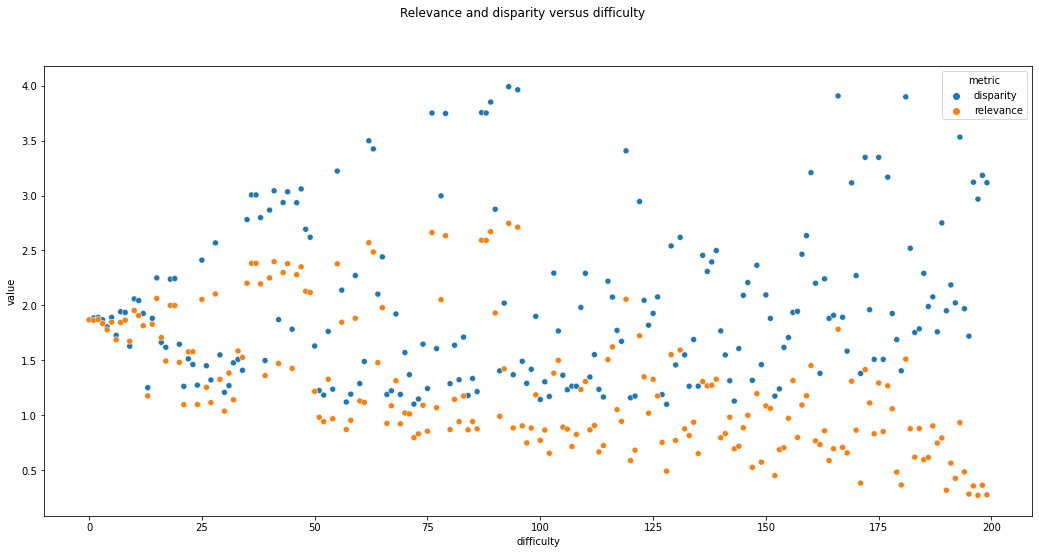

In [39]:
fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

## 5. Obvious mistakes

# Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.